In [ ]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-t4m4ikpu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-t4m4ikpu
  Resolved https://github.com/facebookresearch/fvcore.git to commit b25ff8c84ebb2fe88b61b7a8994b9571a1e13bab
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ze8kh71j
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ze8kh71j
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65573 sha256=f303ba22a238adbb5ab374a0e886f5a47dc61ac3307521e3334eb6feb63f1940
  Sto

'2.4.1+cu121'

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15792, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 15792 (delta 15), reused 27 (delta 10), pack-reused 15743 (from 1)
Receiving objects: 100% (15792/15792), 6.37 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (11507/11507), done.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 18.2 MB/s 

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json

def fix_category_ids(annotations_file):
    # Define valid category mappings: {Original: New}
    category_mapping = {
        1: 0,  # Farm -> 0
        2: 1,  # Forest -> 1
        3: 2   # Rocky -> 2
    }

    with open(annotations_file, "r") as f:
        data = json.load(f)

    # Fix category_id in annotations
    for annotation in data['annotations']:
        if annotation['category_id'] in category_mapping:
            annotation['category_id'] = category_mapping[annotation['category_id']]
        else:
            print(f"Warning: Found invalid category_id {annotation['category_id']}")

    # Save the updated JSON
    with open(annotations_file, "w") as f:
        json.dump(data, f, indent=4)
    print(f"Fixed {annotations_file}")

# Apply to both train and validation datasets
fix_category_ids("/content/LFF-15/annotations/_annotationstrain.coco.json")
fix_category_ids("/content/LFF-15/annotations/_annotationsval.coco.json")


Fixed /content/LFF-15/annotations/_annotationstrain.coco.json
Fixed /content/LFF-15/annotations/_annotationsval.coco.json


In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
import os
from pycocotools.coco import COCO

def get_coco_dicts(img_dir, annotations_file):
    coco = COCO(annotations_file)
    dataset_dicts = []

    for img_id in coco.imgs.keys():  # Iterate over keys to ensure we have unique image IDs
        record = {}
        img_info = coco.imgs[img_id]

        # Add unique image ID
        record["image_id"] = img_id  # Set the unique image ID from COCO
        record["file_name"] = os.path.join(img_dir, img_info["file_name"])
        record["height"] = img_info["height"]
        record["width"] = img_info["width"]

        ann_ids = coco.getAnnIds(img_id)
        annotations = coco.loadAnns(ann_ids)
        objs = []

        for ann in annotations:
            if ann["iscrowd"]:
                continue
            obj = {
                "bbox": ann["bbox"],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": ann["segmentation"],
                "category_id": ann["category_id"],
                "area": ann["area"],
                "iscrowd": ann["iscrowd"],
            }
            objs.append(obj)

        # Only add annotations if there are objects detected
        if objs:
            record["annotations"] = objs
            dataset_dicts.append(record)

    return dataset_dicts

# Register the dataset
# For training dataset
train_img_dir = "/content/drive/MyDrive/LFF-16/train/images"
train_annotations_file = "/content/drive/MyDrive/LFF-16/train/annotations/_annotationstrain.coco.json"
DatasetCatalog.register("FFR_train", lambda: get_coco_dicts(train_img_dir, train_annotations_file))
MetadataCatalog.get("FFR_train").set(thing_classes=["Farm", "Forest", "Rocky"])

# For validation dataset
val_img_dir = "/content/drive/MyDrive/LFF-16/valid/images"
val_annotations_file = "/content/drive/MyDrive/LFF-16/valid/annotations/_annotationsval.coco.json"
DatasetCatalog.register("FFR_val", lambda: get_coco_dicts(val_img_dir, val_annotations_file))
MetadataCatalog.get("FFR_val").set(thing_classes=["Farm", "Forest", "Rocky"])


namespace(name='FFR_val', thing_classes=['Farm', 'Forest', 'Rocky'])

In [ ]:
import detectron2
import os
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.model_zoo import get_config_file, get_checkpoint_url
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Load configuration
cfg = get_cfg()
cfg.MODEL.DEVICE = 'cuda'
cfg.merge_from_file(get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Pre-trained weights  # Use a pre-trained model
cfg.DATASETS.TRAIN = ("FFR_train",)
cfg.DATASETS.TEST = ("FFR_val",)

cfg.MODEL.ROI_HEADS.CLS_LOSS_WEIGHT = [2.0, 1.0, 1.0]
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00005  # Fine-tuning learning rate
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.STEPS = (2000, 4000)  # Reduce LR at these steps
cfg.SOLVER.GAMMA = 0.1  # Learning rate decay factor
cfg.SOLVER.WARMUP_ITERS = 500  # Warmup for smoother start
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Increase this for better fine-tuning
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Farm, Forest, Rocky
cfg.OUTPUT_DIR = "./output"



# Create Trainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Start training
trainer.train()


[10/16 08:38:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 69.5MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[10/16 08:38:05 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/16 08:38:18 d2.utils.events]:  eta: 0:36:13  iter: 19  total_loss: 2.47  loss_cls: 1.362  loss_box_reg: 0.2033  loss_mask: 0.6942  loss_rpn_cls: 0.03682  loss_rpn_loc: 0.1372    time: 0.4362  last_time: 0.4530  data_time: 0.0545  last_data_time: 0.0046   lr: 1.9481e-06  max_mem: 2669M
[10/16 08:38:30 d2.utils.events]:  eta: 0:36:19  iter: 39  total_loss: 2.377  loss_cls: 1.291  loss_box_reg: 0.1815  loss_mask: 0.689  loss_rpn_cls: 0.02834  loss_rpn_loc: 0.1368    time: 0.4430  last_time: 0.4383  data_time: 0.0049  last_data_time: 0.0041   lr: 3.9461e-06  max_mem: 2669M
[10/16 08:38:39 d2.utils.events]:  eta: 0:36:14  iter: 59  total_loss: 2.24  loss_cls: 1.168  loss_box_reg: 0.1949  loss_mask: 0.6808  loss_rpn_cls: 0.01327  loss_rpn_loc: 0.13    time: 0.4463  last_time: 0.4576  data_time: 0.0164  last_data_time: 0.0012   lr: 5.9441e-06  max_mem: 2669M
[10/16 08:38:48 d2.utils.events]:  eta: 0:36:01  iter: 79  total_loss: 2.053  loss_cls: 0.9691  loss_box_reg: 0.1957  loss_mask: 0.6

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Evaluate the model
evaluator = COCOEvaluator("FFR_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "FFR_val")
inference_on_dataset(trainer.model, val_loader, evaluator)


WARNING [10/16 09:20:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/16 09:20:52 d2.evaluation.coco_evaluation]: Trying to convert 'FFR_val' to COCO format ...
[10/16 09:20:52 d2.data.datasets.coco]: Converting annotations of dataset 'FFR_val' to COCO format ...)
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[10/16 09:20:52 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[10/16 09:20:52 d2.data.datasets.coco]: Conversion finished, #images: 382, #annotations: 417
[10/16 09:20:52 d2.data.datasets.coco]: Caching COCO format annotations at './output/FFR_val_coco_format.json' ...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[10/16 09:20:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice

OrderedDict([('bbox',
              {'AP': 87.7167871331306,
               'AP50': 92.20009976105436,
               'AP75': 89.94570526572278,
               'APs': 0.0,
               'APm': 1.9636963696369636,
               'APl': 90.77254767728101,
               'AP-Farm': 87.30712464093516,
               'AP-Forest': 88.74661705091044,
               'AP-Rocky': 87.09661970754617}),
             ('segm',
              {'AP': 85.57753443600467,
               'AP50': 91.23692445994163,
               'AP75': 88.20060525239388,
               'APs': 0.0,
               'APm': 0.935093509350935,
               'APl': 88.67206222369491,
               'AP-Farm': 85.68111178001487,
               'AP-Forest': 84.49627871900117,
               'AP-Rocky': 86.55521280899798})])

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

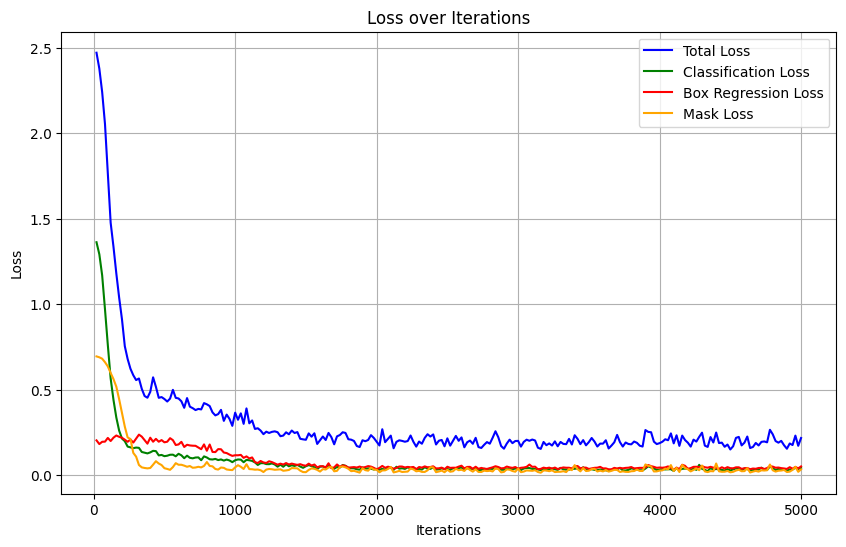

In [10]:
import json
import matplotlib.pyplot as plt

# Path to the metrics.json file
metrics_file = "/content/detectron2_repo/output/metrics.json"

# Read and parse the metrics file
iterations = []
total_loss = []
loss_cls = []
loss_box_reg = []
loss_mask = []
AP = []

with open(metrics_file, "r") as f:
    for line in f:
        metrics = json.loads(line)
        if "iteration" in metrics:
            iterations.append(metrics["iteration"])
        if "total_loss" in metrics:
            total_loss.append(metrics["total_loss"])
        if "loss_cls" in metrics:
            loss_cls.append(metrics["loss_cls"])
        if "loss_box_reg" in metrics:
            loss_box_reg.append(metrics["loss_box_reg"])
        if "loss_mask" in metrics:
            loss_mask.append(metrics["loss_mask"])
        if "bbox/AP" in metrics:
            AP.append(metrics["bbox/AP"])

# Plot Total Loss vs Iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, total_loss, label="Total Loss", color='blue')
plt.plot(iterations, loss_cls, label="Classification Loss", color='green')
plt.plot(iterations, loss_box_reg, label="Box Regression Loss", color='red')
plt.plot(iterations, loss_mask, label="Mask Loss", color='orange')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow
from detectron2.config import get_cfg

# Load configuration and model


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # Set the threshold for predictions
cfg.MODEL.DEVICE='cuda'
# Create predictor
predictor = DefaultPredictor(cfg)

# Load all images from the specified directory
image_dir = "/content/drive/MyDrive/LFF-16/test"  # Update this path to your image directory
image_files = os.listdir(image_dir)  # Get list of all files in the directory

# Loop through each image, predict, and display
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)  # Construct full image path
    im = cv2.imread(image_path)  # Read the image

    if im is None:  # Check if the image is loaded successfully
        print(f"Failed to load image: {image_path}")
        continue  # Skip to the next image

    # Make predictions
    outputs = predictor(im)

    # Visualize the results
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display the result
    cv2_imshow(out.get_image()[:, :, ::-1])  # Show predictions

    cv2.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.